In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt

XLIM_START = 900.0 # usec
START_TIME = 1e6 + XLIM_START # usec
NEW_FLOW_TIME = 1e3 # usec
LINK_PROP_TIME = 1.392 # usec (including serialization)
BW = 100e9
RTT = 8 # usec
UTIL_MEASUREMENT_INTERVAL = RTT
MTU = 1500

FIG_SIZE = (6,4)
LINE_STYLE = (0,(4,4))
LINEWIDTH = 2.5
FONTSIZE = 16
SAVE_FIG = False

In [2]:
log_path = '/google/src/cloud/serhatarslan/bolt/google3/third_party/bolt_cc_ns3/outputs/bolt-bts-benchmarks/'
hpcc_filename = log_path + '0_HPCC_arrAndDep.log'
swift_filename = log_path + '0_SWIFT_arrAndDep'
bolt_filename = log_path + '0_DEFAULT_arrAndDep'

Each line for HPCC log is like:

`2000055540 n:338 4:3 100608 Enqu ecn:0 0b00d101 0b012301 10000 100 U 161000 0 3 1048(1000)`

It means: at time 2000055540ns, at node 338, port 4, queue #3, the queue length is 100608B, and a packet is enqueued; the packet does not have ECN marked, is from 11.0.209.1:10000 to 11.1.35.1:100, is a data packet (U), sequence number 161000, tx timestamp 0, priority group 3, packet size 1048B, payload 1000B.

In [3]:
#@title
def read_hpcc_log(log_filename):

  last_util_time = 0.0
  last_util_size = 0.0

  retval = {}
  retval['q_times'] = []
  retval['q_sizes'] = []
  retval['util_times'] = []
  retval['utils'] = []
  with open(log_filename, 'r') as f:
    for line in f:
      log = line.split()
      time = float(log[0])*1e-3 - START_TIME # in usec
      q_size = float(log[3]) * 8.0 / BW * 1e6 # in usec
      p_size = float(log[14].split('(')[0]) * 8.0 # in bits

      if (log[4] == 'Enqu'):
        retval['q_times'].append(time)
        retval['q_sizes'].append(q_size)
      else:
        last_util_size += p_size

        if (time - last_util_time >= UTIL_MEASUREMENT_INTERVAL):
          util = min(last_util_size / (time - last_util_time) / BW * 100.0e6, 100.0) # in percentage

          retval['util_times'].append(time)
          retval['utils'].append(util)

          last_util_time = time
          last_util_size = 0.0

  return retval

In [4]:
#@title
def read_queue_log(filename):

  last_q_size_bytes = 0.0
  last_util_time = 0.0
  last_util_size = 0.0

  retval = {}
  retval['q_times'] = []
  retval['q_sizes'] = []
  retval['util_times'] = []
  retval['utils'] = []
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-3 - START_TIME # in usec
        q_size_bytes = float(queue_log[1]) # in Bytes
        q_size = q_size_bytes * 8.0 / BW * 1e6 # in usec

        retval['q_times'].append(time)
        retval['q_sizes'].append(q_size)

        if (q_size_bytes < last_q_size_bytes):
          # This is an dequeue event
          p_size = last_q_size_bytes - q_size_bytes 
          last_util_size += p_size * 8.0

          if (time - last_util_time >= UTIL_MEASUREMENT_INTERVAL):
            util = min(last_util_size / (time - last_util_time) / BW * 100.0e6, 100.0) # in percentage

            retval['util_times'].append(time)
            retval['utils'].append(util)

            last_util_time = time
            last_util_size = 0.0

        last_q_size_bytes = q_size_bytes
      except:
        continue

  return retval

In [5]:
#@title
def get_cum_cwnd(flow_stats):
  last_cwnd_of_senders = {}
  for sender in flow_stats.keys():
    last_cwnd_of_senders[sender] = 0

  cum_cwnds = {
      'times': [0],
      'cwnds': [0]
  }

  log_entries = []
  for sender, sender_logs in flow_stats.items():
    for i in range(len(sender_logs['times'])):
      log_entries.append((sender_logs['times'][i], sender_logs['cwnds'][i], sender))
    log_entries.append((log_entries[-1][0],0,sender))

  log_entries = sorted(log_entries, key=lambda x: x[0])

  for entry in log_entries:
    sender = entry[2]
    cum_cwnd = cum_cwnds['cwnds'][-1] - last_cwnd_of_senders[sender] + entry[1]
    cum_cwnds['cwnds'].append(cum_cwnd)
    cum_cwnds['times'].append(entry[0])
    last_cwnd_of_senders[sender] = entry[1]

  return cum_cwnds

In [6]:
#@title
def read_flow_stats(flow_stats_filename):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-3 - START_TIME # in usec
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [7]:
#@title
data = {}
data['hpcc'] = read_hpcc_log(hpcc_filename)

data['swift'] = {}
flow_stats = read_flow_stats(swift_filename+'.log')
cum_cwnds = get_cum_cwnd(flow_stats)
queue_stats = read_queue_log(swift_filename+'.qlen')
data['swift']['q_times'] = queue_stats['q_times']
data['swift']['q_sizes'] = queue_stats['q_sizes']
data['swift']['util_times'] = cum_cwnds['times']
data['swift']['utils'] = [min(cwnd * 1e3 / (BW * RTT * 1e-6 / 8) * 100, 100) for cwnd in cum_cwnds['cwnds']] 
# data['swift']['util_times'] = queue_stats['util_times']
# data['swift']['utils'] = queue_stats['utils']

data['bolt'] = {}
flow_stats = read_flow_stats(bolt_filename+'.log')
cum_cwnds = get_cum_cwnd(flow_stats)
queue_stats = read_queue_log(bolt_filename+'.qlen')
data['bolt']['q_times'] = queue_stats['q_times']
data['bolt']['q_sizes'] = queue_stats['q_sizes']
data['bolt']['util_times'] = cum_cwnds['times']
data['bolt']['utils'] = [min(cwnd * 1e3 / (BW * RTT * 1e-6 / 8) * 100, 100) for cwnd in cum_cwnds['cwnds']] 
# data['bolt']['util_times'] = queue_stats['util_times']
# data['bolt']['utils'] = queue_stats['utils']

In [8]:
#@title
ideal_time = [0.0 - XLIM_START, 
              NEW_FLOW_TIME + LINK_PROP_TIME - XLIM_START, 
              NEW_FLOW_TIME + LINK_PROP_TIME + RTT - XLIM_START, 
              NEW_FLOW_TIME + LINK_PROP_TIME + 2 * RTT - XLIM_START, 
              NEW_FLOW_TIME * 4 - XLIM_START]
ideal_q_size = [0.0, 
                0.0, 
                RTT , 
                0.0, 
                0.0]

In [9]:
xlim = [900 - XLIM_START, 1750 - XLIM_START]

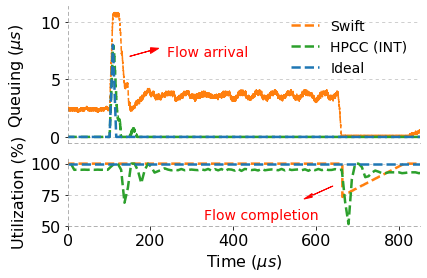

In [10]:
#@title
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

a0.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
a0.set_ylabel('Queuing ($\\mu s$)', fontsize=FONTSIZE)
# plt.step(data['bolt']['q_times'], data['bolt']['q_sizes'], label='Bolt', 
#          where='post', color='C0', linestyle='--', linewidth=LINEWIDTH)
a0.step(data['swift']['q_times'], data['swift']['q_sizes'], label='Swift', 
        where='post', color='C1', linestyle='--', linewidth=LINEWIDTH-1.0)
a0.step(data['hpcc']['q_times'], data['hpcc']['q_sizes'], label='HPCC (INT)', 
        where='post', color='C2', linestyle='--', linewidth=LINEWIDTH)
a0.plot(ideal_time, ideal_q_size, linestyle='--', linewidth=LINEWIDTH, label='Ideal', color='C0')
a0.arrow(150, 7, 50, 0.5, head_width=0.5, color='red', head_length=20)
a0.text(240, 7, 'Flow arrival', color='red', fontsize=FONTSIZE-2)
a0.set_xlim(xlim)
leg = a0.legend(loc='upper right', frameon=False, ncol=1, fontsize=FONTSIZE-2)
for line in leg.get_lines():
    line.set_linewidth(LINEWIDTH)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
a0.get_xaxis().set_visible(False)
a0.tick_params(axis='y', which='major', labelsize=FONTSIZE)

a0.spines["right"].set_linestyle(LINE_STYLE)
a0.spines["right"].set_alpha(0.75)
a0.spines["right"].set_color('gray')
a0.spines["left"].set_linestyle(LINE_STYLE)
a0.spines["left"].set_alpha(0.75)
a0.spines["left"].set_color('gray')
a0.spines["top"].set_linestyle(LINE_STYLE)
a0.spines["top"].set_alpha(0.75)
a0.spines["top"].set_color('gray')
a0.spines["bottom"].set_linestyle(LINE_STYLE)
a0.spines["bottom"].set_alpha(0.75)
a0.spines["bottom"].set_color('gray')

f.tight_layout()

a1.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
a1.set_ylabel('Utilization (%)', fontsize=FONTSIZE)
a1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
# plt.plot(data['bolt']['util_times'], data['bolt']['utils'], label='Bolt', 
#          color='C0', linestyle='--', linewidth=LINEWIDTH)
a1.plot(data['swift']['util_times'], data['swift']['utils'], label='Swift', 
        color='C1', linestyle='--', linewidth=LINEWIDTH)
a1.plot(data['hpcc']['util_times'], data['hpcc']['utils'], label='HPCC (INT)', 
        color='C2', linestyle='--', linewidth=LINEWIDTH)
a1.axhline(y=100, linestyle='--', color='C0', label='Ideal', linewidth=LINEWIDTH)
a1.arrow(640, 82, -50, -7.5, head_width=3, color='red', head_length=20)
a1.text(330, 55, 'Flow completion', color='red', fontsize=FONTSIZE-2)
a1.set_xlim(xlim)
a1.set_ylim((50,105))
a1.set_yticks([50,75,100])
# plt.legend(loc='lower center', frameon=False, ncol=4)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.tick_params(axis='both', which='major', labelsize=FONTSIZE)

a1.spines["right"].set_linestyle(LINE_STYLE)
a1.spines["right"].set_alpha(0.75)
a1.spines["right"].set_color('gray')
a1.spines["left"].set_linestyle(LINE_STYLE)
a1.spines["left"].set_alpha(0.75)
a1.spines["left"].set_color('gray')
a1.spines["top"].set_linestyle(LINE_STYLE)
a1.spines["top"].set_alpha(0.75)
a1.spines["top"].set_color('gray')
a1.spines["bottom"].set_linestyle(LINE_STYLE)
a1.spines["bottom"].set_alpha(0.75)
a1.spines["bottom"].set_color('gray')

f.tight_layout()

f.align_ylabels()
if (SAVE_FIG):
  f.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/hpcc_swift_aggregated_feedback.pdf')
plt.show()

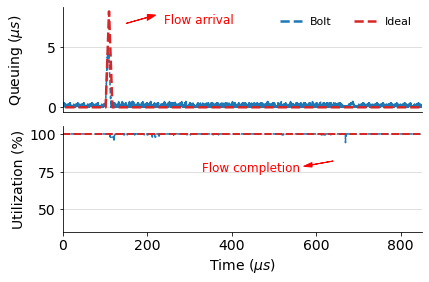

In [11]:
#@title
fig = plt.figure()
label_fontsize = 14

plt.subplot(2,1,1)
plt.grid(axis='y', alpha=0.5)
plt.ylabel('Queuing ($\\mu s$)', fontsize=label_fontsize)
plt.step(data['bolt']['q_times'], data['bolt']['q_sizes'],'--', label='Bolt', where='post', color='C0')
# plt.step(data['swift']['q_times'], data['swift']['q_sizes'],'--', linewidth='0.5', label='Swift', where='post', color='C1')
# plt.step(data['hpcc']['q_times'], data['hpcc']['q_sizes'],'--', label='HPCC (INT)', where='post', color='C2')
plt.plot(ideal_time, ideal_q_size,'--', linewidth='2.5', label='Ideal', color='C3')
plt.arrow(150, 7, 50, 0.5, head_width=0.5, color='red', head_length=20)
plt.text(240, 7, 'Flow arrival', color='red', fontsize=12)
plt.xlim(xlim)
leg = plt.legend(loc='upper right', frameon=False, ncol=4, fontsize=11)
for line in leg.get_lines():
    line.set_linewidth(2.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='y', which='major', labelsize=label_fontsize)
plt.tight_layout()

plt.subplot(2,1,2)
plt.grid(axis='y', alpha=0.5)
plt.ylabel('Utilization (%)', fontsize=label_fontsize)
plt.xlabel('Time ($\\mu s$)', fontsize=label_fontsize)
plt.plot(data['bolt']['util_times'], data['bolt']['utils'],'--', linewidth='1.5', label='Bolt', color='C0')
# plt.plot(data['swift']['util_times'], data['swift']['utils'],'--', linewidth='2.5', label='Swift', color='C1')
# plt.plot(data['hpcc']['util_times'], data['hpcc']['utils'],'--', label='HPCC (INT)', color='C2')
plt.axhline(y=100, linestyle='--', color='C3', label='Ideal', linewidth='2')
plt.arrow(640, 82, -50, -2.5, head_width=3, color='red', head_length=20)
plt.text(330, 75, 'Flow completion', color='red', fontsize=12)
plt.xlim(xlim)
plt.ylim((35,105))
# plt.legend(loc='lower center', frameon=False, ncol=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='major', labelsize=label_fontsize)
plt.tight_layout()

fig.align_ylabels()
if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/bolt_feedback.pdf')
plt.show()

In [12]:

flow_arrival_xlim = (97,192) 
flow_completion_xlim = (605, 880)

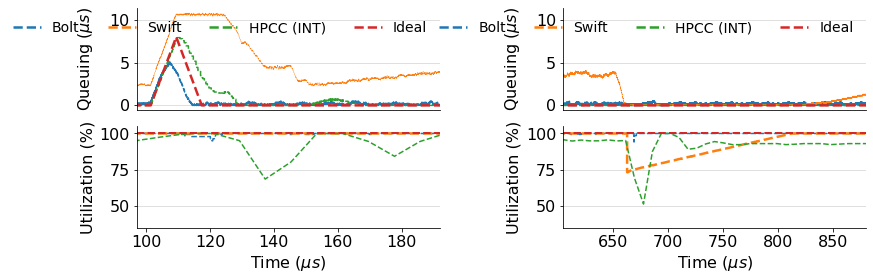

In [13]:
#@title
fig = plt.figure(figsize=(12,4))

i = 1
for cur_xlim in [flow_arrival_xlim, flow_completion_xlim]:
  plt.subplot(2,2,i)
  plt.grid(axis='y', alpha=0.5)
  plt.ylabel('Queuing ($\\mu s$)', fontsize=FONTSIZE)
  plt.step(data['bolt']['q_times'], data['bolt']['q_sizes'],'--', label='Bolt', where='post', color='C0')
  plt.step(data['swift']['q_times'], data['swift']['q_sizes'],'--', linewidth='0.5', label='Swift', where='post', color='C1')
  plt.step(data['hpcc']['q_times'], data['hpcc']['q_sizes'],'--', label='HPCC (INT)', where='post', color='C2')
  plt.plot(ideal_time, ideal_q_size,'--', linewidth='2.5', label='Ideal', color='C3')
  # plt.arrow(250, 7.5, 100, 0.5, head_width=0.5, color='red', head_length=20)
  # plt.text(390, 7.5, 'Flow arrival', color='red', fontsize=FONTSIZE-2)
  plt.xlim(cur_xlim)
  leg = plt.legend(loc='upper right', frameon=False, ncol=4, fontsize=FONTSIZE-2)
  for line in leg.get_lines():
      line.set_linewidth(2.5)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().tick_params(axis='y', which='major', labelsize=FONTSIZE)
  plt.tight_layout()
  i += 1

for cur_xlim in [flow_arrival_xlim, flow_completion_xlim]:
  plt.subplot(2,2,i)
  plt.grid(axis='y', alpha=0.5)
  plt.ylabel('Utilization (%)', fontsize=FONTSIZE)
  plt.xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
  plt.plot(data['bolt']['util_times'], data['bolt']['utils'],'--', linewidth='1.5', label='Bolt', color='C0')
  plt.plot(data['swift']['util_times'], data['swift']['utils'],'--', linewidth='2.5', label='Swift', color='C1')
  plt.plot(data['hpcc']['util_times'], data['hpcc']['utils'],'--', label='HPCC (INT)', color='C2')
  plt.axhline(y=100, linestyle='--', color='C3', label='Ideal', linewidth='2')
  # plt.arrow(1150, 80, -100, -2.5, head_width=3, color='red', head_length=20)
  # plt.text(630, 75, 'Flow completion', color='red', fontsize=FONTSIZE-2)
  plt.xlim(cur_xlim)
  plt.ylim((35,105))
  # plt.legend(loc='lower center', frameon=False, ncol=4)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.gca().tick_params(axis='both', which='major', labelsize=FONTSIZE)
  plt.tight_layout()
  i += 1

fig.align_ylabels()
plt.show()

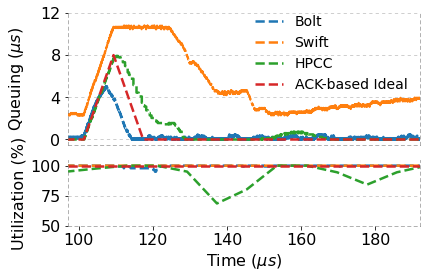

In [14]:
#@title
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

a0.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
a0.set_ylabel('Queuing ($\\mu s$)', fontsize=FONTSIZE)
a0.step(data['bolt']['q_times'], data['bolt']['q_sizes'], label='Bolt', 
        where='post', color='C0', linestyle='--', linewidth=LINEWIDTH)
a0.step(data['swift']['q_times'], data['swift']['q_sizes'], label='Swift', 
        where='post', color='C1', linestyle='--', linewidth=LINEWIDTH-0.5)
a0.step(data['hpcc']['q_times'], data['hpcc']['q_sizes'], label='HPCC', 
        where='post', color='C2', linestyle='--', linewidth=LINEWIDTH)
a0.plot(ideal_time, ideal_q_size,label='ACK-based Ideal', 
        color='C3', linestyle='--', linewidth=LINEWIDTH)
# a0.arrow(250, 7.5, 100, 0.5, head_width=0.5, color='red', head_length=20)
# a0.text(390, 7.5, 'Flow arrival', color='red', fontsize=12)
a0.set_xlim(flow_arrival_xlim)
a0.set_yticks([0,4,8,12])
leg = a0.legend(loc='upper right', frameon=False, ncol=1, fontsize=FONTSIZE-2,
                bbox_to_anchor=(1.0, 1.08),)
for line in leg.get_lines():
    line.set_linewidth(LINEWIDTH)
a0.spines['top'].set_visible(False)
# a0.spines['right'].set_visible(False)
a0.get_xaxis().set_visible(False)
# a0.tick_params(axis='x',label1On=False)
a0.tick_params(axis='y', which='major', labelsize=FONTSIZE)

f.tight_layout()

a0.spines["right"].set_linestyle(LINE_STYLE)
a0.spines["right"].set_alpha(0.75)
a0.spines["right"].set_color('gray')
a0.spines["left"].set_linestyle(LINE_STYLE)
a0.spines["left"].set_alpha(0.75)
a0.spines["left"].set_color('gray')
a0.spines["top"].set_linestyle(LINE_STYLE)
a0.spines["top"].set_alpha(0.75)
a0.spines["top"].set_color('gray')
a0.spines["bottom"].set_linestyle(LINE_STYLE)
a0.spines["bottom"].set_alpha(0.75)
a0.spines["bottom"].set_color('gray')

a1.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
a1.set_ylabel('Utilization (%)', fontsize=FONTSIZE)
a1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
a1.plot(data['bolt']['util_times'], data['bolt']['utils'], label='Bolt', 
        color='C0', linestyle='--', linewidth=LINEWIDTH)
a1.plot(data['swift']['util_times'], data['swift']['utils'], label='Swift', 
        color='C1', linestyle='--', linewidth=LINEWIDTH)
a1.plot(data['hpcc']['util_times'], data['hpcc']['utils'], label='HPCC', 
        color='C2', linestyle='--', linewidth=LINEWIDTH)
a1.axhline(y=100, linestyle='--', linewidth=LINEWIDTH, color='C3', label='RTT-based Ideal')
# a1.arrow(1150, 80, -100, -2.5, head_width=3, color='red', head_length=20)
# a1.text(630, 75, 'Flow completion', color='red', fontsize=12)
a1.set_xlim(flow_arrival_xlim)
a1.set_ylim((50,105))
a1.set_yticks([50,75,100])
# a1.legend(loc='lower center', frameon=False, ncol=4)
a1.spines['top'].set_visible(False)
# a1.spines['right'].set_visible(False)
a1.tick_params(axis='both', which='major', labelsize=FONTSIZE)

a1.spines["right"].set_linestyle(LINE_STYLE)
a1.spines["right"].set_alpha(0.75)
a1.spines["right"].set_color('gray')
a1.spines["left"].set_linestyle(LINE_STYLE)
a1.spines["left"].set_alpha(0.75)
a1.spines["left"].set_color('gray')
a1.spines["top"].set_linestyle(LINE_STYLE)
a1.spines["top"].set_alpha(0.75)
a1.spines["top"].set_color('gray')
a1.spines["bottom"].set_linestyle(LINE_STYLE)
a1.spines["bottom"].set_alpha(0.75)
a1.spines["bottom"].set_color('gray')

f.tight_layout()
f.align_ylabels()
if (SAVE_FIG):
  f.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/bolt_hpcc_swift_aggregated_feedback.pdf')